In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

In [2]:
df_energy = pd.read_csv('data/Energy_Transition.csv')
df_energy.head()

,ObjectId,Country,ISO2,ISO3,Indicator,Technology,Energy_Type,Unit,Source,CTS_Name,...,F2011,F2012,F2013,F2014,F2015,F2016,F2017,F2018,F2019,F2020
0,1,Advanced Economies,NaN,AETMP,Electricity Generation,Bioenergy,Total Renewable,Gigawatt-hours (GWh),International Renewable Energy Agency (IRENA) ...,NaN,...,208500.849,224904.936,239773.166,252341.180,264181.433,274068.035,283583.581,287858.956,293917.663,296348.479
1,2,Advanced Economies,NaN,AETMP,Electricity Installed Capacity,Bioenergy,Total Renewable,Megawatt (MW),International Renewable Energy Agency (IRENA) ...,NaN,...,41776.427,43690.635,46115.653,48575.397,50782.092,53205.387,55580.629,58470.495,59285.425,59698.238
2,3,Advanced Economies,NaN,AETMP,Electricity Generation,Fossil fuels,Total Non-Renewable,Gigawatt-hours (GWh),International Renewable Energy Agency (IRENA) ...,NaN,...,6184941.257,6192108.018,6103628.918,5966341.171,5895296.029,5862708.121,5724991.355,5780558.599,5552191.520,5239862.113
3,4,Advanced Economies,NaN,AETMP,Electricity Installed Capacity,Fossil fuels,Total Non-Renewable,Megawatt (MW),International Renewable Energy Agency (IRENA) ...,NaN,...,1548870.635,1549434.445,1536047.763,1543835.825,1520799.171,1507492.990,1504881.823,1519986.073,1496654.330,1487980.682
4,5,Advanced Economies,NaN,AETMP,Electricity Generation,Geothermal energy,Total Renewable,Gigawatt-hours (GWh),International Renewable Energy Agency (IRENA) ...,NaN,...,37192.016,38076.418,38936.706,40294.245,40949.973,40915.479,41096.979,41910.671,41891.049,42477.806


In [3]:
df_energy = df_energy.drop(['ObjectId', 'ISO2', 'ISO3', 'Source', 'CTS_Name', 'CTS_Code', 'CTS_Full_Descriptor'], axis=1)
df_energy.rename({'Energy_Type': 'Energy Type'}, axis=1, inplace=True)

# regular expressions to format the years column names and units
for col in df_energy.columns:
    if re.match(r'F\d{4}', col):
        new_col = re.sub(r'F(\d{4})', r'\1', col)
        df_energy.rename(columns={col: new_col}, inplace=True)

df_energy.head()

,Country,Indicator,Technology,Energy Type,Unit,2000,2001,2002,2003,2004,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Advanced Economies,Electricity Generation,Bioenergy,Total Renewable,Gigawatt-hours (GWh),110053.796,106524.006,116718.930,124214.129,135792.431,...,208500.849,224904.936,239773.166,252341.180,264181.433,274068.035,283583.581,287858.956,293917.663,296348.479
1,Advanced Economies,Electricity Installed Capacity,Bioenergy,Total Renewable,Megawatt (MW),18788.046,20371.893,21203.368,23002.811,24826.460,...,41776.427,43690.635,46115.653,48575.397,50782.092,53205.387,55580.629,58470.495,59285.425,59698.238
2,Advanced Economies,Electricity Generation,Fossil fuels,Total Non-Renewable,Gigawatt-hours (GWh),5564064.840,5504484.424,5688040.566,5840829.880,5916234.065,...,6184941.257,6192108.018,6103628.918,5966341.171,5895296.029,5862708.121,5724991.355,5780558.599,5552191.520,5239862.113
3,Advanced Economies,Electricity Installed Capacity,Fossil fuels,Total Non-Renewable,Megawatt (MW),1241564.571,1285952.868,1351010.805,1397854.522,1423110.001,...,1548870.635,1549434.445,1536047.763,1543835.825,1520799.171,1507492.990,1504881.823,1519986.073,1496654.330,1487980.682
4,Advanced Economies,Electricity Generation,Geothermal energy,Total Renewable,Gigawatt-hours (GWh),26919.100,26474.100,27225.065,27854.065,28572.826,...,37192.016,38076.418,38936.706,40294.245,40949.973,40915.479,41096.979,41910.671,41891.049,42477.806


In [4]:
df_world_gen = df_energy[(df_energy['Country'] == 'World') & (df_energy['Indicator'] == 'Electricity Generation')]
df_world_cap = df_energy[(df_energy['Country'] == 'World') & (df_energy['Indicator'] == 'Electricity Installed Capacity')]

# Renewable vs. Non-renewable energy generation
df_world_gtype = df_world_gen.groupby(['Energy Type']).sum()
df_world_gtype.reset_index(inplace=True)

df_world_gtype = pd.melt(df_world_gtype, id_vars=['Energy Type'], var_name='Year', value_name='Energy generation (GWH)')

#Renweable vs. Non-renewable energy capacity
df_world_ctype = df_world_cap.groupby(['Energy Type']).sum()
df_world_ctype.reset_index(inplace=True)

df_world_ctype = pd.melt(df_world_ctype, id_vars=['Energy Type'], var_name='Year', value_name='Energy capacity (MW)')

<AxesSubplot:xlabel='Year', ylabel='Energy generation (GWH)'>

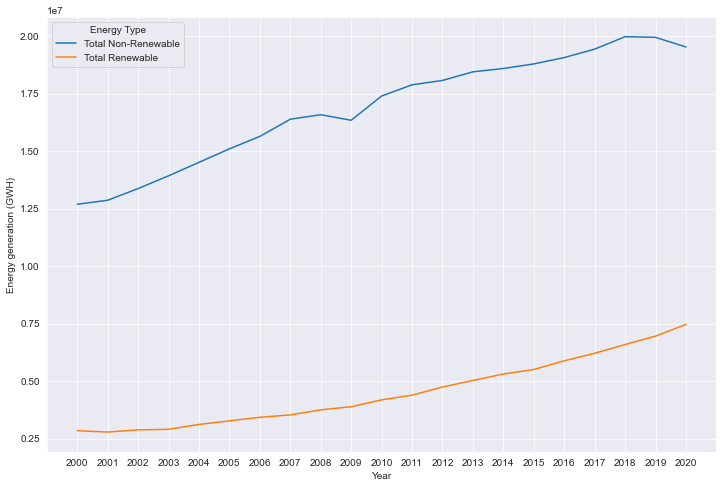

In [6]:
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_world_gtype, x='Year', y='Energy generation (GWH)', hue='Energy Type')

<AxesSubplot:xlabel='Year', ylabel='Energy capacity (MW)'>

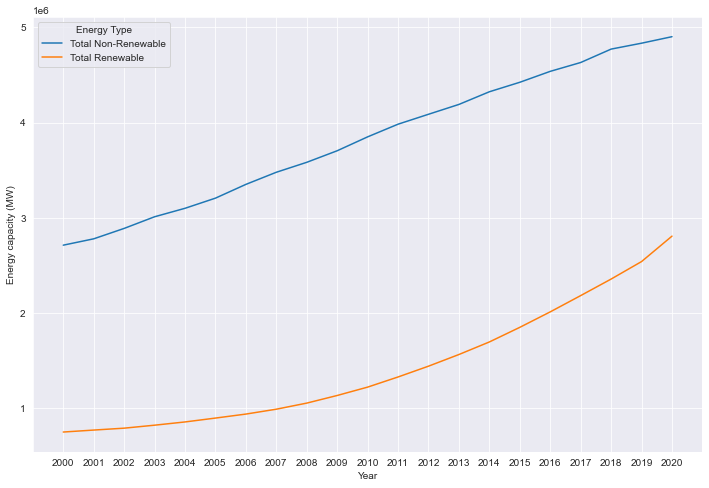

In [7]:
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_world_ctype, x='Year', y='Energy capacity (MW)', hue='Energy Type')

In [9]:
world_tech_cap = df_world_gen.groupby(['Technology']).sum()
world_tech_cap.reset_index(inplace=True)
world_tech_cap = pd.melt(world_tech_cap, id_vars=['Technology'], var_name='Year', value_name='Energy generation (GWH)')

<AxesSubplot:xlabel='Year', ylabel='Energy generation (GWH)'>

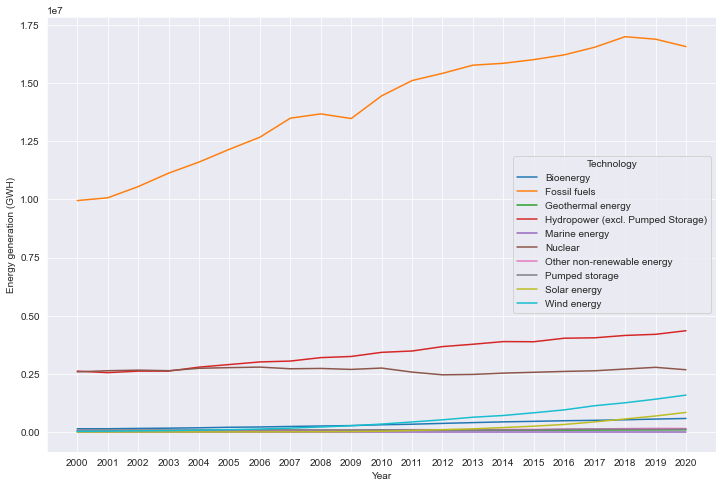

In [10]:
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
sns.lineplot(data=world_tech_cap, x='Year', y='Energy generation (GWH)', hue='Technology')

In [11]:
world_tech_cap = df_world_cap.groupby(['Technology']).sum()
world_tech_cap.reset_index(inplace=True)
world_tech_cap = pd.melt(world_tech_cap, id_vars=['Technology'], var_name='Year', value_name='Energy capacity (MW)')

<AxesSubplot:xlabel='Year', ylabel='Energy capacity (MW)'>

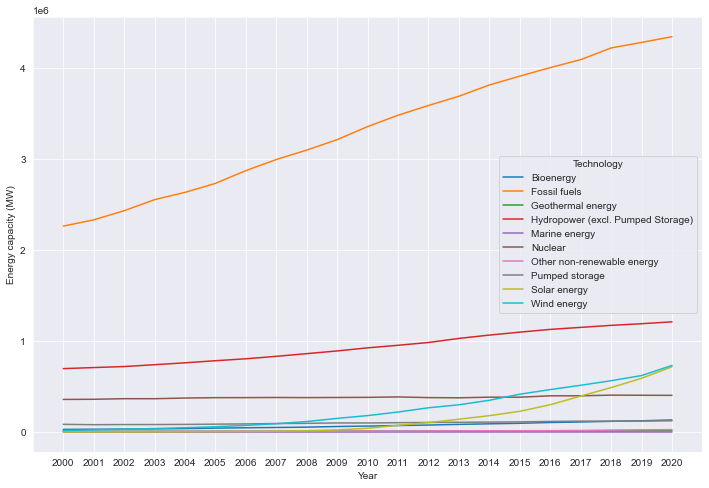

In [12]:
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
sns.lineplot(data=world_tech_cap, x='Year', y='Energy capacity (MW)', hue='Technology')